# Integrate Inference Recommender With Your Existing PythonSDK Model Workflows

* SDK https://sagemaker.readthedocs.io/en/stable/api/inference/model.html#sagemaker.model.Model.right_size
* boto3 https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/sagemaker.html#client

In this notebook we will demonstrate the following PythonSDK workflow:
1. Download the Model & Payload
2. Create the Python SDK model
3. Register the Model with Model Registry
4. Run an Inference Recommendations Job
5. Inspect the contents of the Inference Recommendations
6. Review detailed CloudWatch metrics
7. Deploy the model 
8. Perform inference off of the deployed model
9. Clean up

When demonstrating this PythonSDK workflow, we will be using an SKLearn model.

**This sample is provided for demonstration purposes, make sure to conduct appropriate testing if derivating this code for your own use-cases!**

# Step 0: Make sure that you're using the latest PythonSDK and Boto3 (Feel free to skip if already on latest versions)

In [ ]:
!pip install --upgrade pip awscli botocore boto3  --quiet

## Set up Client and Session

In [ ]:
import sagemaker
import boto3
import time

region = boto3.Session().region_name
role = sagemaker.get_execution_role()
sm_client = boto3.client("sagemaker", region_name=region)
sagemaker_session = sagemaker.Session()

# Step 1: Download the Model & Payload

In this example, we are using a pre-trained scikit-learn model, trained on the California Housing dataset, present in Scikit-Learn: https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_california_housing.html. The California Housing dataset was originally published in:

> Pace, R. Kelley, and Ronald Barry. "Sparse spatial auto-regressions." Statistics & Probability Letters 33.3 (1997): 291-297.

## Download the Model

In [ ]:
import os

export_dir = "./model/"

if not os.path.exists(export_dir):
    os.makedirs(export_dir)
    print("Directory ", export_dir, " Created ")
else:
    print("Directory ", export_dir, " already exists")

model_archive_name = "sk-model.tar.gz"

In [ ]:
!aws s3 cp s3://aws-ml-blog/artifacts/scikit_learn_bring_your_own_model/model.joblib {export_dir}

## Tar the model and code

In [ ]:
!tar -cvpzf {model_archive_name} -C ./model "model.joblib" -C ../code "inference.py"

## Download the payload 

In [ ]:
payload_location = "./sample-payload/"

if not os.path.exists(payload_location):
    os.makedirs(payload_location)
    print("Directory ", payload_location, " Created ")
else:
    print("Directory ", payload_location, " already exists")

payload_archive_name = "sk_payload.tar.gz"

In [ ]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
import pandas as pd

data = fetch_california_housing()

X_train, X_test, y_train, y_test = train_test_split(
    data.data, data.target, test_size=0.25, random_state=42
)

# we don't train a model, so we will need only the testing data
testX = pd.DataFrame(X_test, columns=data.feature_names)
# Save testing data to CSV
testX[data.feature_names].head(10).to_csv(
    os.path.join(payload_location, "test_data.csv"), header=False, index=False
)

## Tar the payload

In [ ]:
!cd ./sample-payload/ && tar czvf ../{payload_archive_name} *

## Upload Your model and payload to S3

We will be uploading the pretrained model and corresponding test set as `sk-model.tar.gz` and as `sk_payload.tar.gz` to S3.

In [ ]:
prefix = "sagemaker/scikit-learn-inference-recommender"

model_url = sagemaker_session.upload_data(model_archive_name, key_prefix=prefix)
sample_payload_url = sagemaker_session.upload_data(payload_archive_name, key_prefix=prefix)

print("model uploaded to: {}".format(model_url))
print("sample payload uploaded to: {}".format(sample_payload_url))

# Step 2: Create the Python SDK model

In this example we will be using a PythonSDK `SKLearnModel` model

In [ ]:
from sagemaker.sklearn.model import SKLearnModel
from sagemaker import image_uris

model = SKLearnModel(
    model_data=model_url,
    role=role,
    image_uri=image_uris.retrieve(
        framework="sklearn", region=region, version="1.0-1", image_scope="inference"
    ),
    entry_point="./code/inference.py",
    framework_version="1.0-1",
)

# Step 3: Register the Model with Model Registry (Will be optional in future releases of PythonSDK)

We will be calling PythonSDK `.register()` to create a `model_package` and `model_package_group` for the `SKLearnModel`

In [ ]:
model_package_group_name = "sample-notebook-package-group-" + str(round(time.time()))
model_package = model.register(
    content_types=["text/csv"],
    response_types=["text/csv"],
    model_package_group_name=model_package_group_name,
    image_uri=model.image_uri,
    approval_status="Approved",
)

# Step 4: Run an Inference Recommendations Job for the Registered Model

The PythonSDK method for Inference Recommender is `.right_size()`

## Let us run a simple Default Inference Recommendations Job

In [ ]:
job_name = "sample-notebook-inference-recommendation-job" + str(round(time.time()))
model_package.right_size(
    job_name=job_name
    sample_payload_url=sample_payload_url,
    supported_content_types=["text/csv"],
    supported_instance_types=["ml.c5.large"],
    framework="SAGEMAKER-SCIKIT-LEARN"
)

## If you want to run an Advanced Inference Recommendations Job here's a basic load test to show how:
```
from sagemaker.parameter import CategoricalParameter
from sagemaker.inference_recommender.inference_recommender_mixin import ( 
    Phase, 
    ModelLatencyThreshold
)

advanced_job_name = (
    "sample-notebook-inference-recommendation-job" + "-load-test-" + str(round(time.time()))
)

hyperparameter_ranges = [
    {
        "instance_types": CategoricalParameter(["ml.m5.xlarge", "ml.g4dn.xlarge"]),
        'OMP_NUM_THREADS': CategoricalParameter(['1', '2', '3']),
    }
]

phases = [
    Phase(duration_in_seconds=300, initial_number_of_users=2, spawn_rate=2),
    Phase(duration_in_seconds=300, initial_number_of_users=14, spawn_rate=2)
]

model_latency_thresholds = [
    ModelLatencyThreshold(percentile="P95", value_in_milliseconds=100)
]

model_package.right_size(
    job_name=advanced_job_name
    sample_payload_url=sample_payload_url,
    supported_content_types=["text/csv"],
    framework="SAGEMAKER-SCIKIT-LEARN",
    job_duration_in_seconds=3600,
    hyperparameter_ranges=hyperparameter_ranges,
    phases=phases, # TrafficPattern
    max_invocations=100, # StoppingConditions
    model_latency_thresholds=model_latency_thresholds,
    max_tests=5, # ResourceLimit
    max_parallel_tests=5
)
```

# Step 5: Inspect the contents of the Inference Recommendations
- `.inference_recommender_job_results` to get the full response JSON
- invoke `describe_inference_recommendations_job` API to get the full response JSON
- `.inference_recommendations` to get just the recommendations response JSON

In [ ]:
model_package.inference_recommender_job_results

In [ ]:
inference_recommendation_res = sm_client.describe_inference_recommendations_job(JobName=job_name)
print(inference_recommendation_res)

In [ ]:
model_package.inference_recommendations

# Step 6. Review detailed CloudWatch metrics

Below we've provided a helper script cloudwatch.py that you can import to get access to functions for reviewing CW metrics. Just by providing your region and Inference Recommender job name you can get detailed charts of your endpoints during the load test.

| Metric | Description |
| --- | --- |
| **OverheadLatency** | The interval of time added to the time taken to respond to a client request by SageMaker overheads. This interval is measured from the time SageMaker receives the request until it returns a response to the client, minus the ModelLatency. Overhead latency can vary depending on multiple factors, including request and response payload sizes, request frequency, and authentication/authorization of the request. <br /> **Units**: Microseconds |
| **CPUUtilization** | The sum of each individual CPU core's utilization. The CPU utilization of each core range is 0–100. For example, if there are four CPUs, the CPUUtilization range is 0%–400%. For processing jobs, the value is the CPU utilization of the processing container on the instance. <br /> For training jobs, the value is the CPU utilization of the algorithm container on the instance. <br /> For batch transform jobs, the value is the CPU utilization of the transform container on the instance. <br /> For endpoint variants, the value is the sum of the CPU utilization of the primary and supplementary containers on the instance. <br /> Note: <br /> For multi-instance jobs, each instance reports CPU utilization metrics. However, the default view in CloudWatch shows the average CPU utilization across all instances. <br /> **Units**: Percent |
| **MemoryUtilization** | The percentage of memory that is used by the containers on an instance. This value range is 0%–100%. <br /> For processing jobs, the value is the memory utilization of the processing container on the instance. <br /> For training jobs, the value is the memory utilization of the algorithm container on the instance. <br /> For batch transform jobs, the value is the memory utilization of the transform container on the instance. <br /> For endpoint variants, the value is the sum of the memory utilization of the primary and supplementary containers on the instance. <br /> **Units**: Percent |

Learn more about CloudWatch: https://docs.aws.amazon.com/sagemaker/latest/dg/monitoring-cloudwatch.html

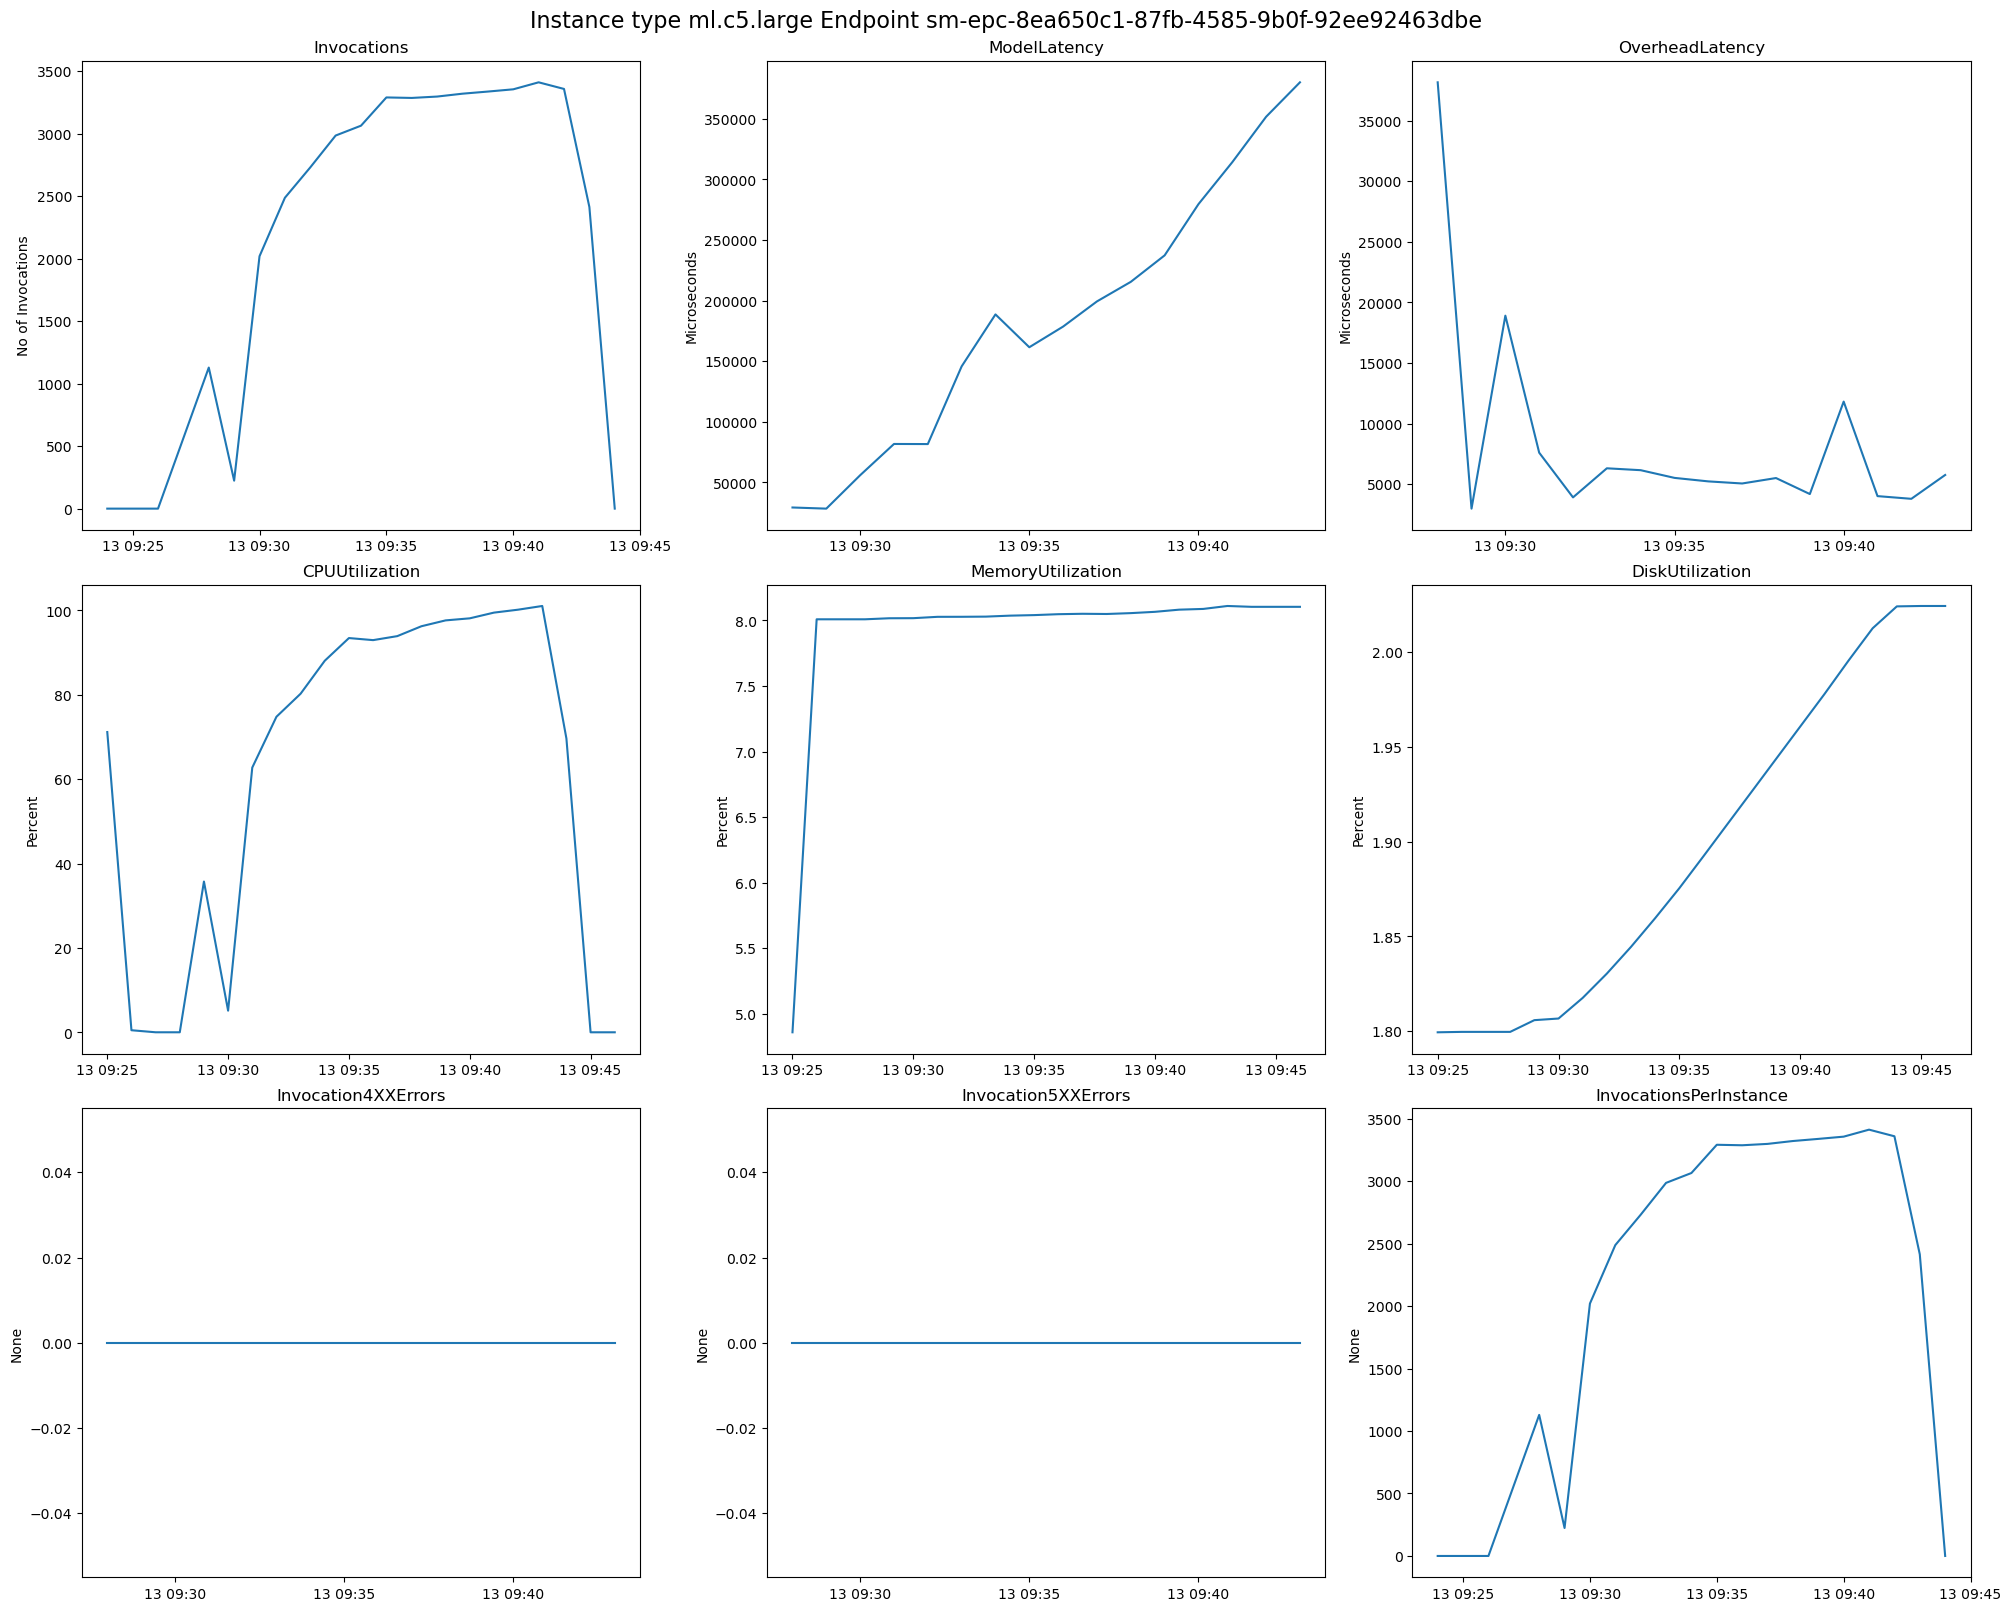

In [60]:
from cloudwatch import get_endpoint_metrics

default_job_name = ""
cw_client = boto3.client("cloudwatch", region)
df_cw = get_endpoint_metrics(sm_client, cw_client, region, job_name, include_plots=True)

## View Inference Recommender CloudWatch metrics(Advanced Job)
You can also observe load test metrics as seen by Inference Recommender. Inference Recommender publishes the following metrics to the `/aws/sagemaker/InferenceRecommendationsJobs` CloudWatch name space. 

| Metric | Description |
| --- | --- |
| **ClientInvocations** | The number of `InvokeEndpoint` requests sent to a model endpoint as seen by Inference Recommender. To get the total number of requests sent to a model endpoint, use the Sum statistic. <br /> **Units**: None <br /> **Valid statistics**: Sum | 
| **ClientInvocationErrors** | The number of `InvokeEndpoint` requests that failed as seen by Inference Recommender. <br /> **Units**: None <br /> **Valid statistics**: Sum | 
| **ClientLatency** | The interval of time taken by a model to respond as seen by Inference Recommender. Note that the time is in milliseconds, where as ModelLatency endpoint invocation metric is in microseconds. <br /> **Units**: Milliseconds <br /> **Valid statistics**: Average, Sum, Min, Max, Sample Count, percentiles | 
| **NumberOfUsers** | The number of users sending `InvokeEndpoint` requests sent to a model endpoint. <br /> **Units**: None <br /> **Valid statistics**: Max, Min, Average

We will graph the "ClientInvocations" metric of the first recommendation in the job result as an example.  

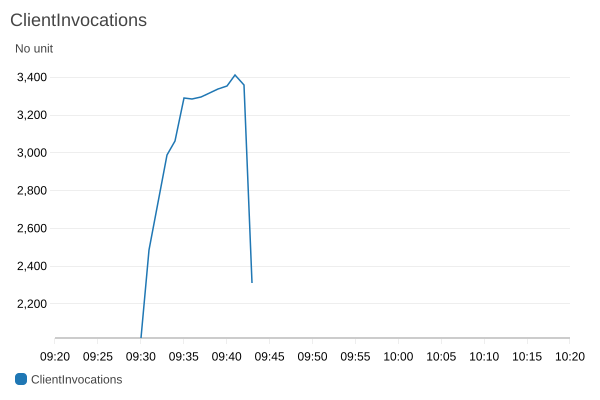

In [67]:
from PIL import Image
from io import BytesIO
import json

cloudwatch_client = boto3.client("cloudwatch")

endpoint_name = inference_recommendation_res["InferenceRecommendations"][0][
    "EndpointConfiguration"
]["EndpointName"]
widget = {
    "metrics": [
        [
            "/aws/sagemaker/InferenceRecommendationsJobs",
            "ClientInvocations",
            "JobName",
            advanced_job_name,
            "EndpointName",
            endpoint_name,
        ]
    ],
    "title": "ClientInvocations",
    "view": "timeSeries",
    "start": "-PT1H",
    "end": "P0D",
    "stat": "Sum",
    "period": 60,
}

widget_string = json.dumps(widget)

response = cloudwatch_client.get_metric_widget_image(MetricWidget=widget_string)

Image.open(BytesIO(response["MetricWidgetImage"]))

# Step 7: Deploy the model to an endpoint 
By default, invoking `deploy` after `right_size` will deploy the first recommendation in the recommendation list.
You can choose to deploy the desried commendation with recommendation id, reference the `optional` below.

In [ ]:
from sagemaker.sklearn.model import SKLearnPredictor
import uuid


model_package.predictor_cls = SKLearnPredictor

endpoint_name = "notebook-test-" + str(uuid.uuid4())
predictor = model_package.deploy(endpoint_name=endpoint_name)

## Optional: deploy specific recommendation with recommendation id

In [ ]:
from sagemaker.sklearn.model import SKLearnPredictor
import uuid

# Substitue recommendation_id with the one you wanna deploy
recommendation_id = ""
model_package.predictor_cls = SKLearnPredictor

endpoint_name = "notebook-test-" + str(uuid.uuid4())
predictor = model_package.deploy(recommendation_id=recommendation_id, endpoint_name=endpoint_name)

# Step 8: Produce Inference

In [ ]:
import pandas as pd

payload = pd.read_csv("./sample-payload/test_data.csv")

inference = predictor.predict(payload)

print(inference)

# Step 9: Cleanup

Cleanup the resources if needed

In [ ]:
# Delete model and endpoint
predictor.delete_model()
predictor.delete_endpoint()

# Delete Model Package
sagemaker_session.sagemaker_client.delete_model_package(
    ModelPackageName=model_package.model_package_arn
)
sagemaker_session.sagemaker_client.delete_model_package_group(
    ModelPackageGroupName=model_package_group_name
)

# Conclusion
This notebook illustrates how to use SageMaker Inference Recommender's new feature API `right_size` to invoke the inference recommendation job and `inference_recommendation_id` support in `deploy` method to deploy the recommendations. The notebook work you through dowloading a pre-trained scikit-learn model, registering your model in Model Registry, create an inference Recommendation Default job or Advanced job, inspect recommendation result and deploy it, invoke endpoint to produce inference and clean up the resources created.